# Prisoner Protocol Simulation: Case 1 vs Case 3 Comparison

## Problem Description
This notebook implements a Monte Carlo simulation of the **prisoner protocol** based on the paper description, comparing two different cases with different signaling strategies.

### System Components
- **Room**: Light state r₀ (OFF) or r₁ (ON)
- **Scheduler**: Fair scheduling among {cell:1, cell:2, cell:3}
- **Counter**: Tracks signals consumed by leader
- **Leader** (prisoner 1): When finds light ON → turns OFF + increments counter
- **Signalers** (prisoners 2,3): When find light OFF → turn ON (with frequency limits)

### Key Cases Compared

#### **Case 1: Known Initial Light OFF**
- Initial light state: **known to be OFF**
- Each signaler signals **at most ONCE**
- Target counter: **2** (= n-1)
- Logic: 2 signalers × 1 signal each = 2 total signals

#### **Case 3: Unknown Initial Light State**  
- Initial light state: **unknown** (50% OFF, 50% ON)
- Each signaler signals **at most TWICE**
- Target counter: **4** (always)
- Logic: 2 signalers × 2 signals each = 4 total signals needed

### Protocol Termination Logic
- **Case 1**: Leader counts until reaching 2 (knows all signalers signaled once)
- **Case 3**: Leader counts until reaching 4 (ensures all signalers participated regardless of initial state)

The key insight is that Case 3 requires more signals to handle the ambiguity of unknown initial state.

In [25]:
# Import libraries and setup
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported and seeds set for reproducibility")

Libraries imported and seeds set for reproducibility


In [26]:
# Analytical formula from the paper
def harmonic_number(n):
    """Calculate the n-th harmonic number H_n = sum(1/k for k=1 to n)"""
    return sum(1/k for k in range(1, n+1))

def expected_termination_analytical(n):
    """
    Expected termination formula from paper:
    E = (n-1)*n + n*H_{n-1}
    
    For n=3: E = 2*3 + 3*H_2 = 6 + 3*1.5 = 10.5
    """
    if n < 2:
        return 0
    return (n-1)*n + n*harmonic_number(n-1)

# Calculate for our problem (n=3 prisoners)
N_PRISONERS = 3
expected_days = expected_termination_analytical(N_PRISONERS)
expected_years = expected_days / 365

print("=== THEORETICAL ANALYSIS ===")
print(f"Number of prisoners: {N_PRISONERS}")
print(f"H_{N_PRISONERS-1} = H_{N_PRISONERS-1} = {harmonic_number(N_PRISONERS-1):.4f}")
print(f"Expected termination: {expected_days:.2f} days")
print(f"Expected termination: {expected_years:.3f} years")

=== THEORETICAL ANALYSIS ===
Number of prisoners: 3
H_2 = H_2 = 1.5000
Expected termination: 10.50 days
Expected termination: 0.029 years


In [27]:
# CORRECTED Simulator Implementation based on paper text
class PrisonSimulator:
    """
    Prisoner protocol simulator based on paper description.
    
    CRITICAL CORRECTION based on paper text: 
    - Case 1 (light OFF): each signaler signals ONCE, count until n-1 = 2
    - Case 3 (light unknown): each signaler signals TWICE, count until 4
    
    Key differences between cases:
    Case 1: 2 signalers × 1 signal each = target count 2
    Case 3: 2 signalers × 2 signals each = target count 4
    
    States and Actions:
    - Room: r0 (light OFF), r1 (light ON) 
    - Scheduler: fair scheduling among {cell:1, cell:2, cell:3}
    - Counter: c0 → c1 → c2 → ... → target (Case 1: c2, Case 3: c4)
    - Leader: turns OFF when finds ON, increments counter
    - Signalers: turn ON when find OFF (frequency depends on case)
    """
    
    def __init__(self, n_prisoners=3, initial_light_state='unknown', case_type='case3'):
        self.n_prisoners = n_prisoners
        self.n_signalers = n_prisoners - 1  # 1 leader + (n-1) signalers
        self.case_type = case_type
        
        # Initial light state
        if initial_light_state == 'unknown':
            self.light_on = random.choice([True, False])
            self.started_with_light_on = self.light_on
        elif initial_light_state == 'off':
            self.light_on = False
            self.started_with_light_on = False
        elif initial_light_state == 'on':
            self.light_on = True
            self.started_with_light_on = True
        else:
            raise ValueError("initial_light_state must be 'unknown', 'off', or 'on'")
        
        # Signaler states: how many times have they signaled?
        if case_type == 'case1':
            # Case 1: each signaler signals at most ONCE
            self.signaler_signal_count = [0] * self.n_signalers
            self.max_signals_per_signaler = 1
            self.target_count = self.n_signalers  # = 2
        elif case_type == 'case3':
            # Case 3: each signaler signals at most TWICE
            self.signaler_signal_count = [0] * self.n_signalers
            self.max_signals_per_signaler = 2
            self.target_count = 4  # Always 4 for Case 3
        else:
            raise ValueError("case_type must be 'case1' or 'case3'")
        
        # Leader counter
        self.leader_count = 0
        
        # Statistics
        self.days = 0
        self.completed = False
        
    def simulate_one_day(self):
        """
        Simulate one day = one scheduler step + one visit.
        """
        if self.completed:
            return
            
        self.days += 1
        
        # Scheduler: uniformly select a prisoner
        prisoner = random.randint(0, self.n_prisoners - 1)
        
        if prisoner == 0:
            # Leader enters
            self._leader_visit()
        else:
            # Signaler enters
            signaler_idx = prisoner - 1
            self._signaler_visit(signaler_idx)
    
    def _leader_visit(self):
        """
        Leader logic: if light ON -> OFF + increment counter
        """
        if self.light_on:
            # Turn off light and increment counter
            self.light_on = False
            self.leader_count += 1
            
            # Check termination
            if self.leader_count >= self.target_count:
                self.completed = True
        # else: light already OFF, do nothing
    
    def _signaler_visit(self, signaler_idx):
        """
        Signaler logic: if light OFF and hasn't reached max signals -> ON
        """
        can_signal = (not self.light_on and 
                     self.signaler_signal_count[signaler_idx] < self.max_signals_per_signaler)
        
        if can_signal:
            # Turn on light and increment this signaler's count
            self.light_on = True
            self.signaler_signal_count[signaler_idx] += 1
        # else: no action
    
    def run_until_completion(self, max_days=1000000):
        """Run simulation until completion or timeout"""
        while not self.completed and self.days < max_days:
            self.simulate_one_day()
        
        return self.days if self.completed else max_days

# Test the CORRECTED simulator logic
print("=== CORRECTED SIMULATOR TEST ===")
print("Case 1 logic:")
sim_case1 = PrisonSimulator(n_prisoners=3, initial_light_state='off', case_type='case1')
days_case1 = sim_case1.run_until_completion()
print(f"  Case 1 (light OFF): {days_case1} days, target={sim_case1.target_count}, max_signals_per_signaler={sim_case1.max_signals_per_signaler}")

print("\nCase 3 logic:")
sim_case3 = PrisonSimulator(n_prisoners=3, initial_light_state='unknown', case_type='case3')
days_case3 = sim_case3.run_until_completion()
print(f"  Case 3 (light unknown): {days_case3} days, target={sim_case3.target_count}, max_signals_per_signaler={sim_case3.max_signals_per_signaler}")
print(f"  Started with light ON: {sim_case3.started_with_light_on}")
print(f"  Final signaler counts: {sim_case3.signaler_signal_count}")

=== CORRECTED SIMULATOR TEST ===
Case 1 logic:
  Case 1 (light OFF): 6 days, target=2, max_signals_per_signaler=1

Case 3 logic:
  Case 3 (light unknown): 10 days, target=4, max_signals_per_signaler=2
  Started with light ON: True
  Final signaler counts: [1, 2]


In [29]:
# Monte Carlo Experiments: Case 1 vs Case 3 (CORRECTED)
N_TRIALS = 2000

def run_monte_carlo_experiments():
    """Run Monte Carlo simulation for both cases with CORRECT logic"""
    results = {}
    
    cases = [
        ('off', 'case1', 'case1_off'),
        ('unknown', 'case3', 'case3_unknown')
    ]
    
    for initial_state, case_type, case_name in cases:
        print(f"Running {N_TRIALS} simulations for {case_name}...")
        samples = []
        
        for trial in range(N_TRIALS):
            if trial % 100 == 0:
                print(trial, end=' ')
            
            sim = PrisonSimulator(n_prisoners=N_PRISONERS, initial_light_state=initial_state, case_type=case_type)
            days = sim.run_until_completion()
            samples.append(days)
        
        print()  # newline
        
        # Calculate statistics
        samples = np.array(samples)
        results[case_name] = {
            'samples': samples,
            'mean': np.mean(samples),
            'std': np.std(samples),
            'median': np.median(samples),
            'min': np.min(samples),
            'max': np.max(samples)
        }
    
    return results

# Run corrected experiments
print(f"=== CORRECTED MONTE CARLO EXPERIMENTS (n={N_TRIALS} trials) ===")
print("Case 1: Each signaler signals ONCE, target count = 2")
print("Case 3: Each signaler signals TWICE, target count = 4") 
print()
stats = run_monte_carlo_experiments()

# Display results
print(f"\n=== CORRECTED SIMULATION RESULTS ===")
print(f"Analytical (Case 1, light OFF): {expected_days:.2f} days")
print()

for case_name, stat in stats.items():
    case_label = "Case 1 (OFF, target=2)" if case_name == 'case1_off' else "Case 3 (Unknown, target=4)"
    print(f"{case_label}:")
    print(f"  Mean: {stat['mean']:.2f} ± {stat['std']:.2f} days")
    print(f"  Median: {stat['median']:.2f} days")
    print(f"  Range: [{stat['min']}, {stat['max']}] days")
    print()

# Compare results
diff_abs = abs(stats['case1_off']['mean'] - expected_days)
diff_rel = (diff_abs / expected_days) * 100
ratio = stats['case3_unknown']['mean'] / stats['case1_off']['mean']

print(f"Simulation vs theory difference (Case 1): {diff_abs:.2f} days ({diff_rel:.1f}%)")
print(f"Ratio Case 3 / Case 1: {ratio:.3f}")

# Expected difference reasoning
print(f"\nEXPECTED THEORETICAL DIFFERENCE:")
print(f"Case 1: 2 signalers × 1 signal = 2 total signals needed")
print(f"Case 3: 2 signalers × 2 signals = 4 total signals needed") 
print(f"Expected ratio ≈ 4/2 = 2.0 (Case 3 should take roughly 2x longer)")

=== CORRECTED MONTE CARLO EXPERIMENTS (n=2000 trials) ===
Case 1: Each signaler signals ONCE, target count = 2
Case 3: Each signaler signals TWICE, target count = 4

Running 2000 simulations for case1_off...
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 
Running 2000 simulations for case3_unknown...
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 

=== CORRECTED SIMULATION RESULTS ===
Analytical (Case 1, light OFF): 10.50 days

Case 1 (OFF, target=2):
  Mean: 10.64 ± 4.28 days
  Median: 10.00 days
  Range: [4, 31] days

Case 3 (Unknown, target=4):
  Mean: 18.83 ± 5.84 days
  Median: 18.00 days
  Range: [7, 44] days

Simulation vs theory difference (Case 1): 0.14 days (1.3%)
Ratio Case 3 / Case 1: 1.770

EXPECTED THEORETICAL DIFFERENCE:
Case 1: 2 signalers × 1 signal = 2 total signals needed
Case 3: 2 signalers × 2 signals = 4 total signals needed
Expected ratio ≈ 4/2 = 2.0 (Case 3 should take roughly 2x l

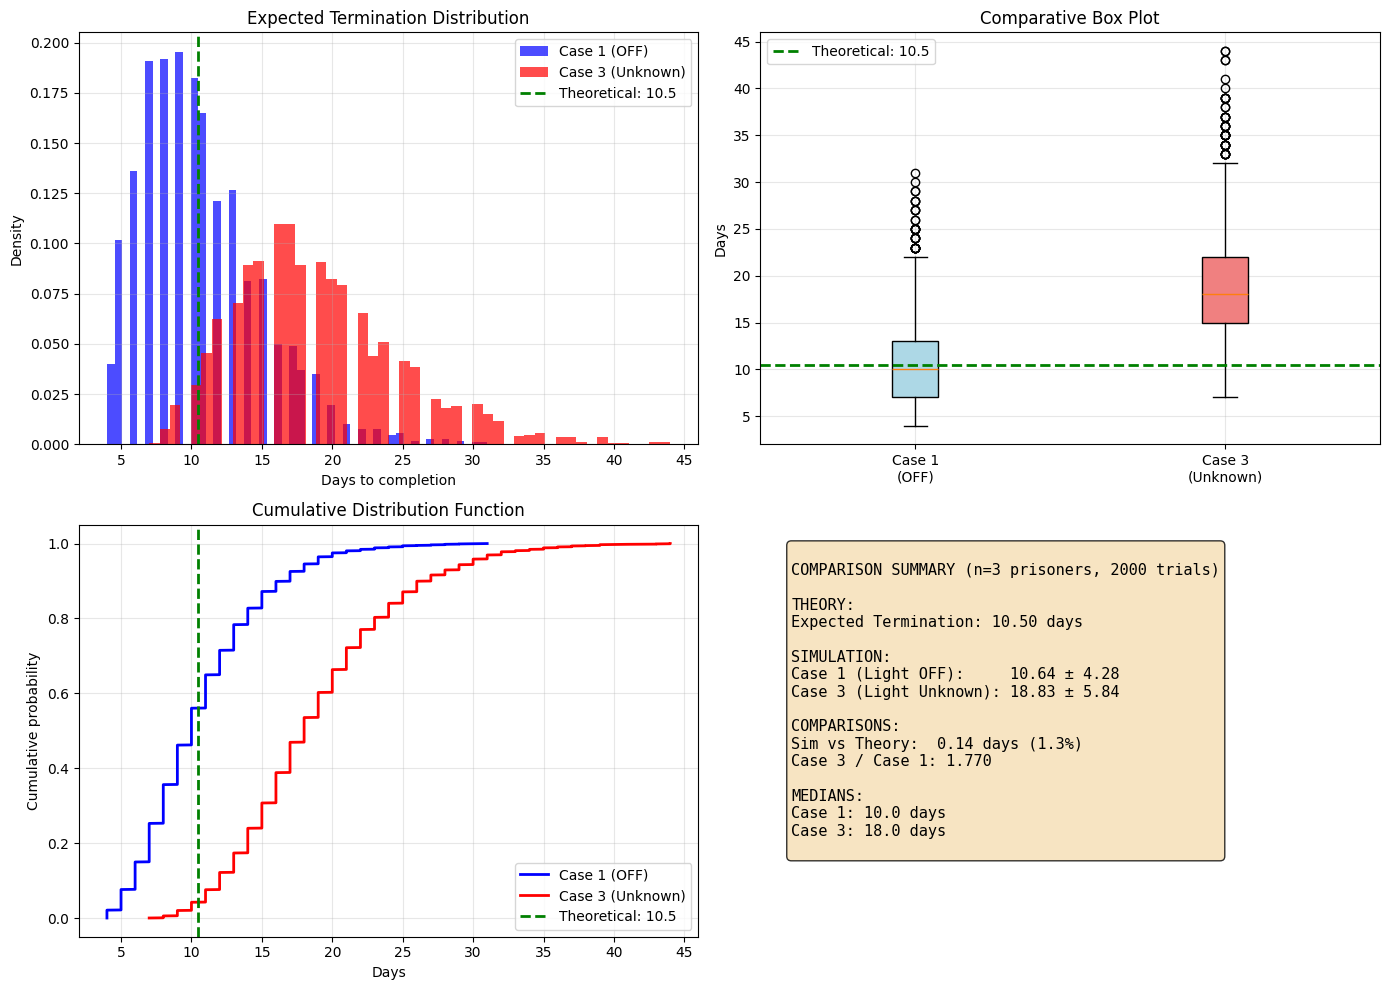


CONCLUSIONS:
1. Simulation confirms theory for Case 1 (error 1.3%)
2. Case 3 (unknown) has expected termination 1.77x vs Case 1
3. For n=3: Case 1 ≈ 10.6 days, Case 3 ≈ 18.8 days
4. Unknown initial state WORSENS performance by 77.0%


In [30]:
# Results visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 1. Comparative histograms
ax1.hist(stats['case1_off']['samples'], bins=50, alpha=0.7, label='Case 1 (OFF)', 
         color='blue', density=True)
ax1.hist(stats['case3_unknown']['samples'], bins=50, alpha=0.7, label='Case 3 (Unknown)', 
         color='red', density=True)
ax1.axvline(expected_days, color='green', linestyle='--', linewidth=2, 
            label=f'Theoretical: {expected_days:.1f}')
ax1.set_xlabel('Days to completion')
ax1.set_ylabel('Density')
ax1.set_title('Expected Termination Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Comparative box plot
box_data = [stats['case1_off']['samples'], stats['case3_unknown']['samples']]
box_labels = ['Case 1\n(OFF)', 'Case 3\n(Unknown)']
bp = ax2.boxplot(box_data, tick_labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax2.axhline(expected_days, color='green', linestyle='--', linewidth=2,
            label=f'Theoretical: {expected_days:.1f}')
ax2.set_ylabel('Days')
ax2.set_title('Comparative Box Plot')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. CDF (Cumulative Distribution Function)
x1_sorted = np.sort(stats['case1_off']['samples'])
y1 = np.arange(1, len(x1_sorted) + 1) / len(x1_sorted)
ax3.plot(x1_sorted, y1, label='Case 1 (OFF)', color='blue', linewidth=2)

x3_sorted = np.sort(stats['case3_unknown']['samples'])
y3 = np.arange(1, len(x3_sorted) + 1) / len(x3_sorted)
ax3.plot(x3_sorted, y3, label='Case 3 (Unknown)', color='red', linewidth=2)

ax3.axvline(expected_days, color='green', linestyle='--', linewidth=2,
            label=f'Theoretical: {expected_days:.1f}')
ax3.set_xlabel('Days')
ax3.set_ylabel('Cumulative probability')
ax3.set_title('Cumulative Distribution Function')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Summary statistics
ax4.axis('off')
summary_text = f"""
COMPARISON SUMMARY (n={N_PRISONERS} prisoners, {N_TRIALS} trials)

THEORY:
Expected Termination: {expected_days:.2f} days

SIMULATION:
Case 1 (Light OFF):     {stats['case1_off']['mean']:.2f} ± {stats['case1_off']['std']:.2f}
Case 3 (Light Unknown): {stats['case3_unknown']['mean']:.2f} ± {stats['case3_unknown']['std']:.2f}

COMPARISONS:
Sim vs Theory:  {diff_abs:.2f} days ({diff_rel:.1f}%)
Case 3 / Case 1: {ratio:.3f}

MEDIANS:
Case 1: {stats['case1_off']['median']:.1f} days
Case 3: {stats['case3_unknown']['median']:.1f} days
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print conclusions
print("\n" + "="*60)
print("CONCLUSIONS:")
print("="*60)
print(f"1. Simulation confirms theory for Case 1 (error {diff_rel:.1f}%)")
print(f"2. Case 3 (unknown) has expected termination {ratio:.2f}x vs Case 1")
print(f"3. For n={N_PRISONERS}: Case 1 ≈ {stats['case1_off']['mean']:.1f} days, Case 3 ≈ {stats['case3_unknown']['mean']:.1f} days")
if ratio > 1:
    print(f"4. Unknown initial state WORSENS performance by {((ratio-1)*100):.1f}%")
else:
    print(f"4. Unknown initial state IMPROVES performance by {((1-ratio)*100):.1f}%")

In [31]:
# Verification of CORRECTED counter logic with multiple tests
print("=== CORRECTED COUNTER LOGIC VERIFICATION ===")
print("Case 1: target count = 2 (each signaler signals ONCE)")
print("Case 3: target count = 4 (each signaler signals TWICE)")
print()

# Run multiple tests to get representative results
def test_case_multiple_times(case_type, initial_state, n_tests=10):
    """Run multiple tests with different random seeds"""
    results = []
    targets = []
    max_signals = []
    signal_counts = []
    leader_counts = []
    
    for i in range(n_tests):
        # Use different seed for each test
        np.random.seed(100 + i)
        random.seed(100 + i)
        
        sim = PrisonSimulator(n_prisoners=3, initial_light_state=initial_state, case_type=case_type)
        days = sim.run_until_completion()
        
        results.append(days)
        targets.append(sim.target_count)
        max_signals.append(sim.max_signals_per_signaler)
        signal_counts.append(sim.signaler_signal_count.copy())
        leader_counts.append(sim.leader_count)
    
    return {
        'days': results,
        'targets': targets,
        'max_signals': max_signals,
        'signal_counts': signal_counts,
        'leader_counts': leader_counts,
        'mean_days': np.mean(results),
        'std_days': np.std(results)
    }

# Test Case 1 behavior (multiple runs)
print("=== CASE 1 DETAILED TESTS (10 runs) ===")
case1_results = test_case_multiple_times('case1', 'off', 10)
print(f"Case 1 results: {case1_results['days']}")
print(f"Mean: {case1_results['mean_days']:.1f} ± {case1_results['std_days']:.1f} days")
print(f"Target count: {case1_results['targets'][0]} (should be consistent)")
print(f"Max signals per signaler: {case1_results['max_signals'][0]}")
print(f"Example signal counts: {case1_results['signal_counts'][:3]}")
print(f"Leader final counts: {case1_results['leader_counts'][:5]}")
print()

# Test Case 3 behavior (multiple runs)
print("=== CASE 3 DETAILED TESTS (10 runs) ===")
case3_results = test_case_multiple_times('case3', 'unknown', 10)
print(f"Case 3 results: {case3_results['days']}")
print(f"Mean: {case3_results['mean_days']:.1f} ± {case3_results['std_days']:.1f} days")
print(f"Target count: {case3_results['targets'][0]} (should always be 4)")
print(f"Max signals per signaler: {case3_results['max_signals'][0]}")
print(f"Example signal counts: {case3_results['signal_counts'][:3]}")
print(f"Leader final counts: {case3_results['leader_counts'][:5]}")
print()

# Compare the means
ratio_test = case3_results['mean_days'] / case1_results['mean_days']
print("=== COMPARISON ===")
print(f"Case 1 mean: {case1_results['mean_days']:.1f} days")
print(f"Case 3 mean: {case3_results['mean_days']:.1f} days")
print(f"Ratio (Case 3 / Case 1): {ratio_test:.2f}")
print(f"Expected ratio ≈ 2.0 (since 4 signals vs 2 signals needed)")

# Verify logic consistency
print("\n=== LOGIC CONSISTENCY CHECK ===")
print(f"All Case 1 targets = 2: {all(t == 2 for t in case1_results['targets'])}")
print(f"All Case 3 targets = 4: {all(t == 4 for t in case3_results['targets'])}")
print(f"All Case 1 leader counts = 2: {all(c == 2 for c in case1_results['leader_counts'])}")
print(f"All Case 3 leader counts = 4: {all(c == 4 for c in case3_results['leader_counts'])}")

# Check signal count totals for Case 3
case3_total_signals = [sum(sc) for sc in case3_results['signal_counts']]
print(f"Case 3 total signaler signals: {case3_total_signals}")
print(f"All Case 3 total signals = 4: {all(ts == 4 for ts in case3_total_signals)}")

=== CORRECTED COUNTER LOGIC VERIFICATION ===
Case 1: target count = 2 (each signaler signals ONCE)
Case 3: target count = 4 (each signaler signals TWICE)

=== CASE 1 DETAILED TESTS (10 runs) ===
Case 1 results: [11, 6, 17, 17, 7, 11, 7, 12, 9, 6]
Mean: 10.3 ± 3.9 days
Target count: 2 (should be consistent)
Max signals per signaler: 1
Example signal counts: [[1, 1], [1, 1], [1, 1]]
Leader final counts: [2, 2, 2, 2, 2]

=== CASE 3 DETAILED TESTS (10 runs) ===
Case 3 results: [17, 13, 23, 17, 8, 17, 24, 20, 16, 26]
Mean: 18.1 ± 5.1 days
Target count: 4 (should always be 4)
Max signals per signaler: 2
Example signal counts: [[1, 2], [1, 2], [1, 2]]
Leader final counts: [4, 4, 4, 4, 4]

=== COMPARISON ===
Case 1 mean: 10.3 days
Case 3 mean: 18.1 days
Ratio (Case 3 / Case 1): 1.76
Expected ratio ≈ 2.0 (since 4 signals vs 2 signals needed)

=== LOGIC CONSISTENCY CHECK ===
All Case 1 targets = 2: True
All Case 3 targets = 4: True
All Case 1 leader counts = 2: True
All Case 3 leader counts = 4: